<a href="https://colab.research.google.com/github/harisonmg/tensorflow-exam-prep/blob/main/notebooks/horses_or_humans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Getting the data

In [1]:
#@title Imports
from pathlib import Path
from zipfile import ZipFile

In [2]:
#@title Config
BASE_DIR = Path(".")
DATASETS = {
    "train": {
        "url":  "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip ",
        "local": "horse-or-human.zip"
    },
    "validation": {
        "url":  "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip",
        "local": "validation-horse-or-human.zip"
    }
}

data_dir = BASE_DIR / "horse_or_human"

In [3]:
#@title Downloading and extracting the data
for name, dataset in DATASETS.items(): 
    dataset_url = dataset["url"]
    dataset_download = dataset["local"]
    subset_dir = data_dir / name
    
    !wget --no-check-certificate {dataset_url} -O {dataset_download}

    with ZipFile(dataset_download, "r") as zip_ref:
        zip_ref.extractall(subset_dir)

--2021-08-17 10:56:51--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M   226MB/s    in 0.6s    

2021-08-17 10:56:52 (226 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]

--2021-08-17 10:56:53--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M

In [4]:
#@title List the number of images per subset
subset_dirs = list(data_dir.glob("*"))
for subset in subset_dirs:
    formatting = "\n" + "="*10 + " "*4
    print(f"{formatting} {subset.name.title()} images {formatting[::-1]}")

    for category in list(subset.glob("*")):
        num_files = len(list(category.glob("*")))
        print(f"{category.name}: {num_files}")

print(f"\nSubset directories: {subset_dirs}")
train_dir = data_dir / "train"
validation_dir = data_dir / "validation"


==========     Train images     ==========

humans: 527
horses: 500

==========     Validation images     ==========

humans: 128
horses: 128

Subset directories: [PosixPath('horse_or_human/train'), PosixPath('horse_or_human/validation')]


## Visualizing the data

In [5]:
#@title Imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

In [6]:
#@title Helper function
def plot_images(data_dir, category_rows=2, cols=4, img_size=4):
    category_paths = [path for path in list(data_dir.glob("*")) if path.is_dir()]
    images = {category.name: list(category.glob("*")) for category in category_paths}

    rows = category_rows * len(category_paths)
    sample_images = {}
    for category, img_paths in images.items():
        sample_images[category] = np.random.choice(
            img_paths, category_rows*cols, replace=False
        )

    fig, axes = plt.subplots(rows, cols, figsize=(img_size*rows, img_size*cols))
    for i, img_data in enumerate(sample_images.items()):
        category, img_paths = img_data
        for j, path in enumerate(img_paths):
            idx = j + i*(category_rows*cols)
            ax = axes[idx//cols, idx%cols]
            img = mpimg.imread(path)
            ax.imshow(img)
            ax.set_title(f"{path.name}: {category}")
            ax.axis("off")
    plt.show()

In [7]:
#@title Plotting sample training images 
# plot_images(train_dir)

In [8]:
#@title Plotting sample validation images 
# plot_images(validation_dir)

## Model training

In [9]:
#@title Imports
from datetime import datetime

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks, layers, models, optimizers
import tensorflow as tf

print(f"Tensorflow: {tf.__version__}")

Tensorflow: 2.5.0


In [10]:
#@title Config
BATCH_SIZE = 32
IMAGE_SIZE = (150, 150)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
MODEL_LOGS_DIR = data_dir / f"{data_dir}_model"

epochs = 200
learning_rate = 1e-4
early_stopping_rounds = 3

current_logs_dir = MODEL_LOGS_DIR / datetime.now().isoformat()
checkpoint_filepath = current_logs_dir / "checkpoints"
tensorboard_logs_dir = current_logs_dir / "logs"

model_log_paths = [checkpoint_filepath, tensorboard_logs_dir]
for path in model_log_paths:
    if not path.exists():
        path.mkdir(parents=True)
        print(f"Created: {path}")

Created: horse_or_human/horse_or_human_model/2021-08-17T10:56:56.322100/checkpoints
Created: horse_or_human/horse_or_human_model/2021-08-17T10:56:56.322100/logs


In [11]:
#@title Model definition
model = models.Sequential([
  layers.Conv2D(16, (3,3), input_shape=IMAGE_SHAPE, activation="relu"),
  layers.MaxPool2D(2,2),
  layers.Conv2D(32, (3,3), activation="relu"),
  layers.Conv2D(32, (3,3), activation="relu"),
  layers.MaxPool2D(2,2),
  layers.Conv2D(64, (3,3), activation="relu"),
  layers.Conv2D(64, (3,3), activation="relu"),
  layers.MaxPool2D(2,2),
  layers.Conv2D(128, (3,3), activation="relu"),
  layers.MaxPool2D(2,2),
  layers.Flatten(),
  layers.Dense(512, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 70, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 31, 31, 64)        3

In [12]:
#@title Loading the data for training
train_datagen = ImageDataGenerator(
    rescale=1/255,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode="nearest"
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [13]:
#@title Model callbacks
class CustomCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    threshold = 0.95
    if(logs.get("val_accuracy") > threshold):
      print(f"\nReached {threshold:.1%} accuracy so cancelling training!")
      self.model.stop_training = True

model_callbacks = [
             CustomCallback(),
             callbacks.ModelCheckpoint(filepath=checkpoint_filepath),
             callbacks.EarlyStopping(patience=early_stopping_rounds),
             callbacks.TensorBoard(tensorboard_logs_dir)
]

In [14]:
#@title Training the model
history = model.fit(
    train_generator,
    epochs=epochs,
    verbose=1,
    validation_data=validation_generator,
    callbacks=model_callbacks
)

Epoch 1/200
33/33 [==============================] - 40s 240ms/step - loss: 0.6088 - accuracy: 0.6943 - val_loss: 0.3926 - val_accuracy: 0.8438
INFO:tensorflow:Assets written to: horse_or_human/horse_or_human_model/2021-08-17T10:56:56.322100/checkpoints/assets
Epoch 2/200
33/33 [==============================] - 7s 209ms/step - loss: 0.3610 - accuracy: 0.8685 - val_loss: 0.6169 - val_accuracy: 0.8203
INFO:tensorflow:Assets written to: horse_or_human/horse_or_human_model/2021-08-17T10:56:56.322100/checkpoints/assets
Epoch 3/200
33/33 [==============================] - 7s 209ms/step - loss: 0.2304 - accuracy: 0.9163 - val_loss: 0.7093 - val_accuracy: 0.8516
INFO:tensorflow:Assets written to: horse_or_human/horse_or_human_model/2021-08-17T10:56:56.322100/checkpoints/assets
Epoch 4/200
33/33 [==============================] - 7s 205ms/step - loss: 0.1692 - accuracy: 0.9396 - val_loss: 0.7050 - val_accuracy: 0.8477
INFO:tensorflow:Assets written to: horse_or_human/horse_or_human_model/2021-

## Model evaluation

In [15]:
#@title Imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")

In [16]:
#@title Helper function
def get_metrics(training_history, metric, validation=True):
    metrics = {
        metric: training_history.get(metric)
    }
    if validation:
        val_metric = "val_" + metric
        metrics[val_metric] = training_history.get(val_metric)
    return pd.DataFrame(metrics)

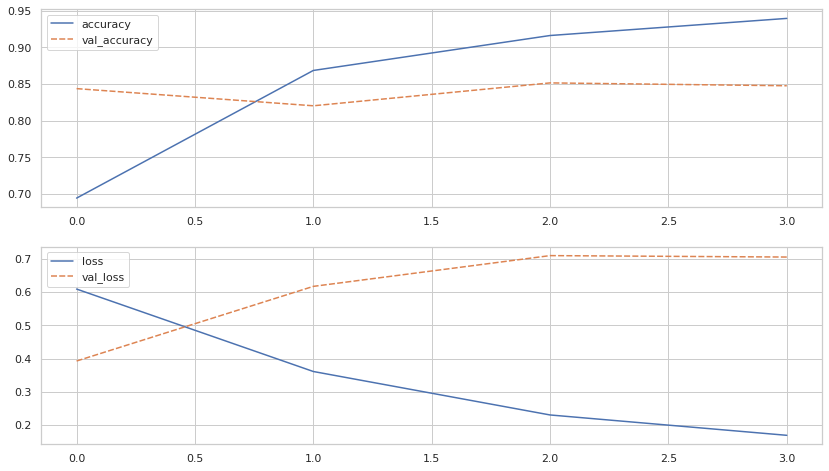

In [17]:
#@title Plot training metrics
rows, cols = 2, 1
fig, axes = plt.subplots(rows, cols, figsize=(7*rows, 8*cols))

accuracy = get_metrics(history.history, "accuracy")
loss = get_metrics(history.history, "loss")
sns.lineplot(data=accuracy, ax=axes[0])
sns.lineplot(data=loss, ax=axes[1])
plt.show()

In [18]:
# %load_ext tensorboard
# %tensorboard --logdir={tensorboard_logs_dir}

In [19]:
#@title Testing the model 
# # Here's a codeblock just for fun. You should be able to upload an image here 
# # and have it classified without crashing

# import numpy as np
# from google.colab import files
# from keras.preprocessing import image

# uploaded = files.upload()

# for fn in uploaded.keys():
 
#   # predicting images
#   path = '/content/' + fn
#   img = image.load_img(path, target_size=(# YOUR CODE HERE))
#   x = image.img_to_array(img)
#   x = np.expand_dims(x, axis=0)

#   images = np.vstack([x])
#   classes = model.predict(images, batch_size=10)
#   print(classes[0])
#   if classes[0]>0.5:
#     print(fn + " is a dog")
#   else:
#     print(fn + " is a cat")

## Saving the model to Google Drive

In [20]:
#@title Copy the model checkpoints and logs to Google Drive
from google.colab import drive

drive.mount('/content/drive')
google_drive_folder = "/content/drive/MyDrive/tensorflow"

!mkdir {google_drive_folder}
!cp -r {MODEL_LOGS_DIR} {google_drive_folder}

Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/MyDrive/tensorflow’: File exists
